### Бусько Полина, гр. 3824М1ПМвм

## Лабораторная работа 2: «Разработка сверточной нейронной сети с использованием PyTorch»


### Цели работы
Цель работы — разработать и обучить сверточную нейронную сеть для задачи классификации изображений на наборе данных CIFAR-10 с использованием фреймворка PyTorch.

### Задачи работы
1. Загрузить набор данных CIFAR-10 и выполнить предобработку данных, если это необходимо.
2. Реализовать сверточную нейронную сеть с использованием фреймворка PyTorch.
3. Выбрать подходящую функцию потерь и настроить гиперпараметры обучения.
4. Обучить реализованную нейронную сеть и провести оценку качества её работы.

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import time

### Набор данных CIFAR-10:

Количество ветных изображений = 60000  
Размер = 32 x 32 пикселя  
Количество классов = 10

**0:** plane   
**1:** car  
**2:** bird  
**3:** cat  
**4:** deer  
**5:** dog  
**6:** frog  
**7:** horse  
**8:** ship  
**9:** truck

Загрузка данных с использованием библиотеки torchvision

1) **Compose**: контейнер, который позволяет последовательно применять несколько преобразований к изображению.  
2) **transforms.ToTensor**: Преобразует изображение (которое обычно представляется в формате numpy-матрицы) в тензор PyTorch,
где значения пикселей нормализованы в диапазон [0, 1].  
3) **transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)):** Нормализует тензор изображения, вычитая среднее значение (заданное первым кортежем) и деля на стандартное отклонение (заданное вторым кортежем): нормализация выполняется для каждого из трёх каналов RGB -> преобразует значения пикселей в диапазон от [-1, 1] (+ часто улучшает обучение нейронных сетей)

In [47]:
# объект, который последовательно применяет несколько операций (преобразований) к входным изображениям.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=transform)

In [48]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True, num_workers=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, pin_memory=True, num_workers=4, shuffle=False)

In [49]:
print(f'Размер тренировочной выборки изображений: {train_loader.dataset.data.shape}')
print(f'Размер тренировочной выборки меток: ({len(train_loader.dataset.targets)})\n')
print(f'Размер тестовой выборки изображений: {test_loader.dataset.data.shape}')
print(f'Размер тестовой выборки меток: ({len(test_loader.dataset.targets)})')

Размер тренировочной выборки изображений: (50000, 32, 32, 3)
Размер тренировочной выборки меток: (50000)

Размер тестовой выборки изображений: (10000, 32, 32, 3)
Размер тестовой выборки меток: (10000)


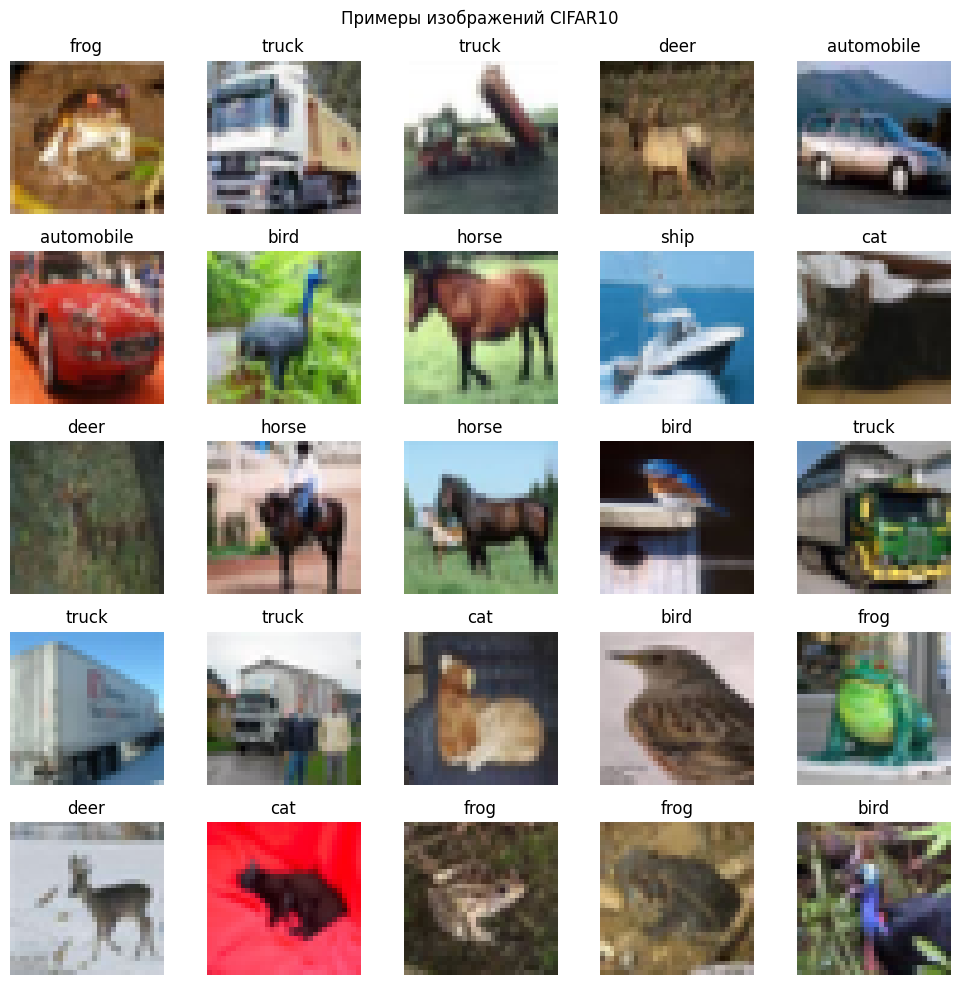

In [50]:
def plot_cifar10(dataset):
    size = 5
    fig, axes = plt.subplots(size, size, figsize=(10, 10))
    fig.suptitle("Примеры изображений CIFAR10")

    for i in range(size):
        for j in range(size):
            index = i * size + j
            axes[i, j].imshow(dataset.data[index], cmap=plt.cm.binary)
            axes[i, j].axis('off')
            axes[i, j].set_title(dataset.classes[dataset.targets[index]], )
    plt.tight_layout()
    plt.show()


plot_cifar10(train_data)

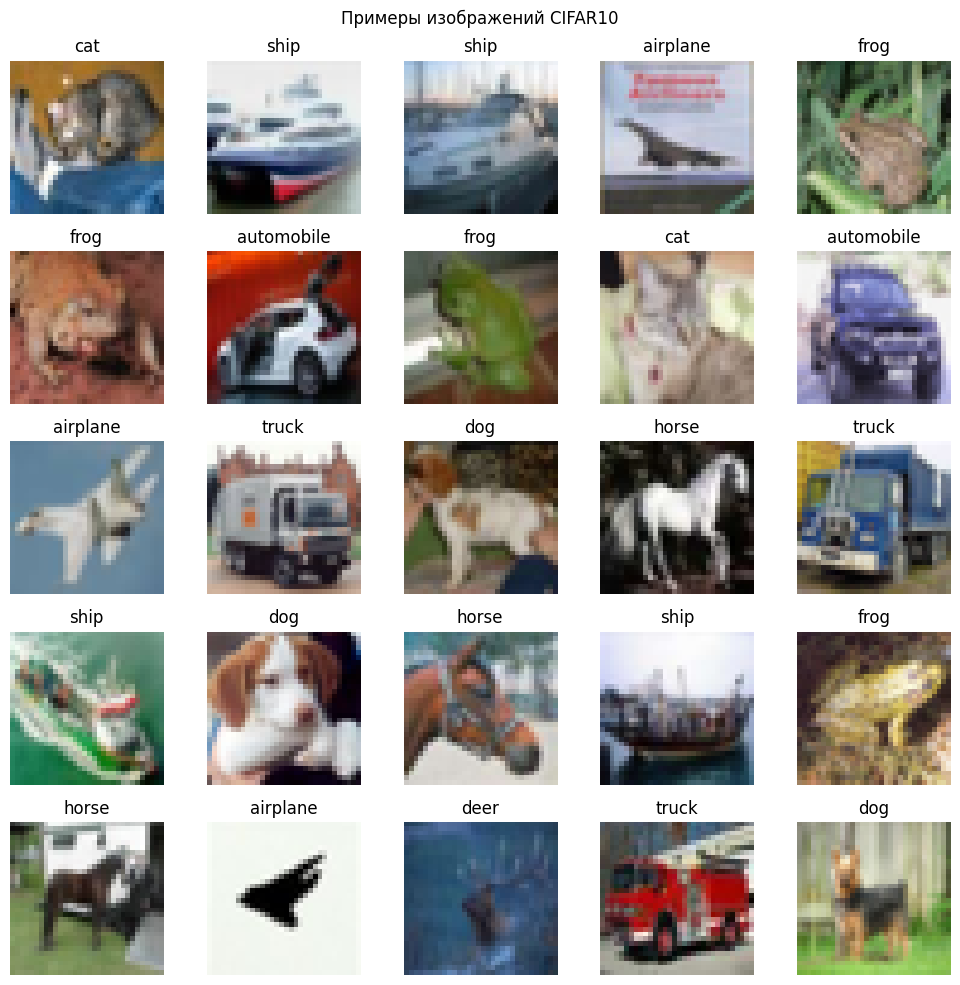

In [51]:
plot_cifar10(test_data)

## Архитектура сверточной нейронной сети

Вход -> 8 сверточных слоев -> глобальный пуллинг (для выравнивания выходов) -> полносвязный слой (финальная классификация).

#### Структура сверточного блока:
+ Conv2d  
+ BatchNorm2d
+ ReLu
+ MaxPoll2d (опционально)

#### Описание

Каналы: 3 -> 64 -> 64 -> 128 -> 128 -> 256 -> 256 -> 512 -> 512  
Размер: 32 -> 32 -> 32 -> 16 -> 16 -> 8 -> 8 -> 4 -> 4 -> 1

Входное изображение: 3 канала 32 х 32

|| | Описание | Выходные данные | Количество обучаемых параметров |
|-|-|-|-|-|
| 1 | Conv2d, padding=1 | Входное изображение → 64 каналов | [-1, 64, 32, 32] | 1,792 |
|   | BatchNorm2d | Нормализация активаций | [-1, 64, 32, 32] | 128 |
|   | ReLU | Функция активации | [-1, 64, 32, 32] | -- |
| 2 | Conv2d, padding=1 | 64 канала → 64 канала | [-1, 64, 32, 32] | 36,928 |
|   | BatchNorm2d | Нормализация активаций | [-1, 64, 32, 32] | 128 |
|   | ReLU | Функция активации | [-1, 64, 32, 32] | -- |
| 3 | Conv2d, padding=1 | 64 канала → 128 каналов | [-1, 128, 32, 32] | 73,856 |
|   | BatchNorm2d | Нормализация активаций | [-1, 128, 32, 32] | 256 |
|   | ReLU | Функция активации | [-1, 128, 32, 32] | -- |
|   | MaxPool2d | Уменьшение размера в 2 раза | [-1, 128, 16, 16] | -- |
| 4 | Conv2d, padding=1 | 128 каналов → 128 каналов | [-1, 128, 16, 16] | 147,584 |
|   | BatchNorm2d | Нормализация активаций | [-1, 128, 16, 16] | 256 |
|   | ReLU | Функция активации | [-1, 128, 16, 16] | -- |
| 5 | Conv2d, padding=1 | 128 каналов → 256 каналов | [-1, 256, 16, 16] | 295,168 |
|   | BatchNorm2d | Нормализация активаций | [-1, 256, 16, 16] | 512 |
|   | ReLU | Функция активации | [-1, 256, 16, 16] | -- |
|   | MaxPool2d | Уменьшение размера в 2 раза | [-1, 256, 8, 8] | -- |
| 6 | Conv2d, padding=1 | 256 каналов → 256 каналов | [-1, 256, 8, 8] | 590,080 |
|   | BatchNorm2d | Нормализация активаций | [-1, 256, 8, 8] | 512 |
|   | ReLU | Функция активации | [-1, 256, 8, 8] | -- |
| 7 | Conv2d, padding=1 | 256 каналов → 512 каналов | [-1, 512, 8, 8] | 1,180,160 |
|   | BatchNorm2d | Нормализация активаций | [-1, 512, 8, 8] | 1,024 |
|   | ReLU | Функция активации | [-1, 512, 8, 8] | -- |
|   | MaxPool2d | Уменьшение размера в 2 раза | [-1, 512, 4, 4] | -- |
| 8 | Conv2d, padding=1 | 512 каналов → 512 каналов | [-1, 512, 4, 4] | 2,359,808 |
|   | BatchNorm2d | Нормализация активаций | [-1, 512, 4, 4] | 1,024 |
|=|=============|=============================|==============|===============|
|   | ReLU | Функция активации | [-1, 512, 4, 4] | -- |
|   | MaxPool2d | Уменьшение до 1x1 | [-1, 512, 1, 1] | -- |
|   |  Linear| Полносвязный слой | [-1, 10] | 5,130 |

#### Общее количество параметров:
Сверточные блоки:
1,920 + 37,056 + 74,112 + 147,840 + 295,680 + 590,592 + 1,181,184 + 2,360,832 = 4,689,216

Полносвязный слой: 5,130

Итого: 4,689,216 + 5,130 = 4,694,346 параметров

#### Размеры карт признаков:

```conv_block(3, 64, False)```: 64 карты × 32×32  (колчесвто карт увеличилось на 61, размер не изменился);  
```conv_block(64, 64, False)```: 64 карты × 32×32  (количество карт и их размер не изменились);  
```conv_block(64, 128, True)```: 128 карт × 16×16 (+64 карты, размер уменьшился в 2 раза, так как используеется ядро 2x2 и шаг 2; Карта признаков после maxpool: $128 \cdot (\frac {32-2}{2} + 1 ) \cdot (\frac {32-2}{2} + 1 )$);  
```conv_block(128, 128, False)```: 128 карт × 16×16 (не изменилось);  
```conv_block(128, 256, True)```: 256 карт × 8×8 (+128 карт, размер уменьшился в 2 раза);  
```conv_block(256, 256, False)```: 256 карт × 8×8 (не изменилось);  
```conv_block(256, 512, True)```: 512 карт х 4х4 (+256 карт, размер уменьшился в 2 раза);  
```conv_block(512, 512, False)```: 512 карт × 4×4 (не изменилось).


## Реализация

- ```Conv2d```  сверточный слой с ядром 3x3 и паддингом 1 (сохранение размера).
- ```BatchNorm2d``` слой нормализации по мини-батчу для стабилизации обучения.  
- ```ReLU``` функция активации, которая добавляет нелинейность.  
- ```MaxPooling``` с ядром 2x2 для уменьшения размерности по высоте и ширине в 2 раза.

In [52]:
def conv_block(input_channels, output_channels, pool):
    layers = [nn.Conv2d(input_channels, output_channels, kernel_size = 3, padding = 1), nn.BatchNorm2d(output_channels), nn.ReLU()]

    if pool:
        layers.append(nn.MaxPool2d(2))

    # nn.Sequential (содержит созданные слои).
    return nn.Sequential(*layers)

In [53]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, input_channels = 3, output_channels = 10):
        super(ConvolutionalNeuralNetwork, self).__init__() # родительский конструктор
        self.block1 = nn.Sequential(
            conv_block(input_channels, 64, False),
            conv_block(64, 64, False),
            conv_block(64, 128, True),
            conv_block(128, 128, False),
            conv_block(128, 256, True),
            conv_block(256, 256, False),
            conv_block(256, 512, True),
            conv_block(512, 512, False))


        # Адаптивный пуллинг для выравнивания выходов (приводит каждую карту признаков к размеру 1x1, независимо от исходного размера входа)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512, output_channels)

    def forward(self, x):
        out = self.block1(x)                # Пропуск данных через через последовательность сверточных блоков.
        out = self.adaptive_pool(out)       # Применяем адаптивный пулинг, чтобы получить карты признаков размером 1x1 для каждого канала.
        out = out.view(out.size(0), -1)     # Преобразование в вектор (batch_size, 512)
        out = self.fc(out)                  # Применение полносвязного слоя, чтобы получить выход размером (batch_size, 10)
        return out

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


- ```CrossEntropyLoss``` — это функция потерь, которая используется для задач классификации
- ```optim.Adam``` — это оптимизатор: адаптивно регулирует скорость обучения для каждого параметра модели
- ```model.parameters``` передаёт все параметры модели в оптимизатор для их обновления при обучении (например, веса слоёв).
- ```optimizer``` обновляет параметры модели (например, веса), чтобы минимизировать ошибку, возвращаемую функцией потерь.

In [55]:
model = ConvolutionalNeuralNetwork().to(device)

learning_rate = 0.001

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

### Обучение модели

In [56]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    accuracy_list = []
    loss_list = []

    for data in train_loader:
        images = data[0].to(device)
        labels = data[1].to(device)

        # обнулить градиенты перед обновлением параметров модели
        optimizer.zero_grad()

        # Прямой проход: входные изображения пропускаются через слои модели
        u = model(images)

        # рассчитываем функцию потерь
        loss = criterion(u, labels)
        loss_list.append(loss.item())

        # Обратный проход: вычисляет градиенты потерь по отношению ко всем параметрам модели
        loss.backward()
        # Оптимизатор обновляет веса модели, используя вычисленные градиенты.
        optimizer.step()

        # torch.argmax(u, dim=1): определяем предсказанные классы, который выбирает класс с max(вероят.) для каждого изображения.
        # Сравниваем предсказания с истинными метками и вычисляем среднюю точность для данного батча.
        accuracy_list.append((torch.argmax(u, dim=1) == labels).float().mean())

    # рассчитываем средние значения потерь и точности по всем батчам в текущей эпохе
    avg_loss = torch.tensor(loss_list).mean()
    avg_accuracy = torch.tensor(accuracy_list).mean()

    return avg_loss.cpu().detach().numpy(), avg_accuracy.cpu().detach().numpy()

In [57]:
loss_list = []
acc_list = []

epochs = 20
print("Начало обучения:")
for epoch in range(epochs):
    time_one = time.time()

    avg_loss, avg_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)

    difference_time = time.time() - time_one
    print(f"Эпоха: {epoch + 1}/{epochs}," f"Время работы: {difference_time:.3f}", f"Ошибка: {avg_loss:.6f}," f"Точность: {avg_accuracy:.6f}")

    loss_list.append(avg_loss)
    acc_list.append(avg_accuracy)

total_duration = time.time() - time_one
print(f"Общее время обучения: {total_duration:.3f} сек")
print('Обучение завершено!')

Начало обучения:
Эпоха: 1/20,Время работы: 29.129 Ошибка: 1.148110,Точность: 0.582421
Эпоха: 2/20,Время работы: 24.996 Ошибка: 0.698332,Точность: 0.756474
Эпоха: 3/20,Время работы: 24.664 Ошибка: 0.524326,Точность: 0.816996
Эпоха: 4/20,Время работы: 25.845 Ошибка: 0.415597,Точность: 0.854260
Эпоха: 5/20,Время работы: 25.041 Ошибка: 0.330405,Точность: 0.883971
Эпоха: 6/20,Время работы: 24.810 Ошибка: 0.255019,Точность: 0.910686
Эпоха: 7/20,Время работы: 25.227 Ошибка: 0.195267,Точность: 0.930966
Эпоха: 8/20,Время работы: 25.237 Ошибка: 0.143178,Точность: 0.949728
Эпоха: 9/20,Время работы: 25.938 Ошибка: 0.106380,Точность: 0.962236
Эпоха: 10/20,Время работы: 25.193 Ошибка: 0.083752,Точность: 0.969869
Эпоха: 11/20,Время работы: 25.259 Ошибка: 0.070650,Точность: 0.974724
Эпоха: 12/20,Время работы: 24.991 Ошибка: 0.063623,Точность: 0.977362
Эпоха: 13/20,Время работы: 25.019 Ошибка: 0.046607,Точность: 0.984295
Эпоха: 14/20,Время работы: 25.173 Ошибка: 0.055654,Точность: 0.979839
Эпоха: 15/20

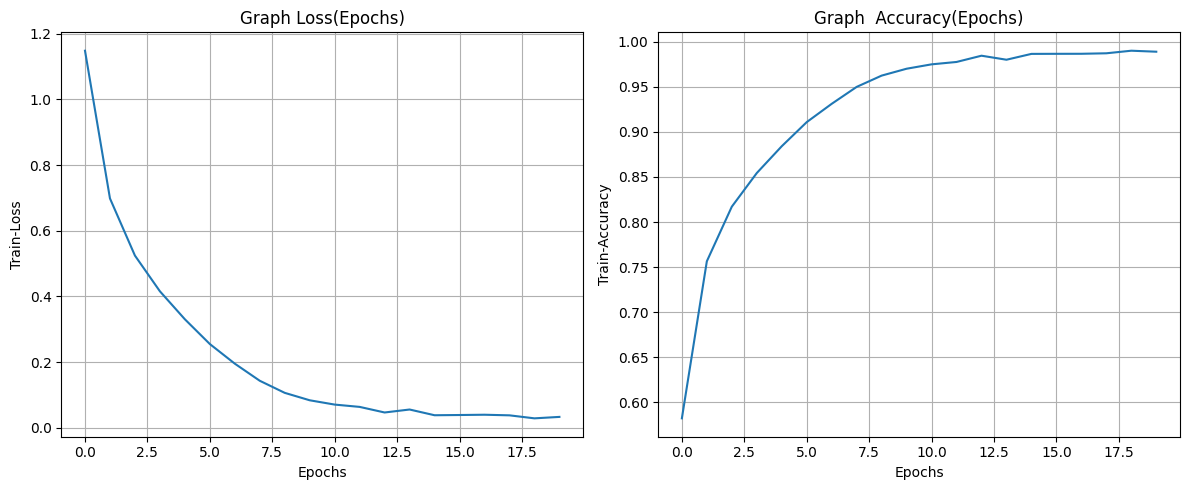

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(loss_list)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train-Loss')
ax1.set_title('Graph Loss(Epochs)')
ax1.grid(True)

ax2.plot(acc_list)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Train-Accuracy')
ax2.set_title('Graph  Accuracy(Epochs)')
ax2.grid(True)

plt.tight_layout()
plt.show()

### Тестириование модели

In [59]:
def test(data_loader):
    loss, accuracy, cur_total = 0, 0, 0

    # На этапе тестирования градиенты не нужны
    with torch.no_grad():
        for data in data_loader:
            images = data[0].to(device)
            labels = data[1].to(device)

            # Прямой проход
            u = model(images)

            # Поетри
            loss += criterion(u, labels).item()
            cur_total += labels.size(0)

            # Получение предсказанных меток: для каждого изображения выбираем индекс с наибольшим значением вероятности
            _, predicted_labels = torch.max(u.data, 1)

            # Количесвто верных редсказаний
            accuracy += (predicted_labels == labels).sum().item()

    print(f"Ошибка: {loss / cur_total:.4f}, Точность: {accuracy / cur_total:.4f}")

In [60]:
test(test_loader)

Ошибка: 0.0102, Точность: 0.8707
